In [3]:
%load_ext autoreload
%autoreload 2
import torch

import os
import sys
module_path = os.path.abspath(os.path.join('../../../src/'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
device = 'cuda' if torch.cuda.is_available() else 'cpu'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load models

In [4]:
from classification.models.SpectrogramCNN import SpectrogramCNNPLModule

state_dict_path = '/nfs/students/summer-term-2020/project-4/data/models/SpectrogramBasedCNN.pt'

hparams = {
    "batch_size": 5,
    "learning_rate": 3e-4,
    "weight_decay": 0.001,
    "lr_decay": 0.95
}

model = SpectrogramCNNPLModule(hparams)
model.model.load_state_dict(torch.load(state_dict_path))
model = model.cuda()
model = model.eval()

# Load Data

In [5]:
from datasets.datasethandler import DatasetHandler
datasetHandler = DatasetHandler()

In [10]:
datasetHandler.load(model, 'validation')
datasetHandler.load(model, 'training')

Load: /nfs/students/summer-term-2020/project-4/data/dataset1/dataset_resampled/training.p


# Attacks

In [72]:
epsilons = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005]

## Simple PGD

In [73]:
from attacks.pgd import ProjectedGradientDescent

pgd_attacks = {}

for eps in epsilons:
    attack_parameters = {'epsilon': eps, 'num_iter': 50}
    pgd = ProjectedGradientDescent(model, model.val_dataloader(), attack_parameters, save_samples=False)
    pgd.attack()
    pgd_attacks[eps] = pgd

100%|██████████| 338/338 [07:55<00:00,  1.41s/it]


In [74]:
for eps in pgd_attacks:
    pgd_attacks[eps].report()
    print()

Attack-Parameters:	{'epsilon': 0.0001, 'num_iter': 50}
Early stopping: 	False (-1)

Successfully attacked:	244
Total attacked: 	1483
Total processed:	1687

Success-Rate: 		0.16
Perturbed Accurracy: 	0.73

Attack-Parameters:	{'epsilon': 0.0002, 'num_iter': 50}
Early stopping: 	False (-1)

Successfully attacked:	506
Total attacked: 	1483
Total processed:	1687

Success-Rate: 		0.34
Perturbed Accurracy: 	0.58

Attack-Parameters:	{'epsilon': 0.0003, 'num_iter': 50}
Early stopping: 	False (-1)

Successfully attacked:	600
Total attacked: 	1483
Total processed:	1687

Success-Rate: 		0.4
Perturbed Accurracy: 	0.52

Attack-Parameters:	{'epsilon': 0.0004, 'num_iter': 50}
Early stopping: 	False (-1)

Successfully attacked:	636
Total attacked: 	1483
Total processed:	1687

Success-Rate: 		0.43
Perturbed Accurracy: 	0.5

Attack-Parameters:	{'epsilon': 0.0005, 'num_iter': 50}
Early stopping: 	False (-1)

Successfully attacked:	666
Total attacked: 	1483
Total processed:	1687

Success-Rate: 		0.45
Pertu

## Functional Attack: PGD + Volume Attack

In [75]:
from attacks.functionalVolume import FunctionalVolumeAttack

functional_volume_attacks = {}

for eps in epsilons:
    attack_parameters = {'epsilonVolume': 0.1, 'epsilonPGD': eps, 'num_iter': 50}
    fva = FunctionalVolumeAttack(model, model.val_dataloader(), attack_parameters, save_samples=True)
    fva.attack()
    functional_volume_attacks[eps] = fva

100%|██████████| 338/338 [08:26<00:00,  1.50s/it]


In [76]:
for eps in functional_volume_attacks:
    print(eps)
    functional_volume_attacks[eps].report()
    print()

0.0001
Attack-Parameters:	{'epsilonVolume': 0.1, 'epsilonPGD': 0.0001, 'num_iter': 50}
Early stopping: 	False (-1)

Successfully attacked:	308
Total attacked: 	1483
Total processed:	1687

Success-Rate: 		0.21
Perturbed Accurracy: 	0.7

0.0002
Attack-Parameters:	{'epsilonVolume': 0.1, 'epsilonPGD': 0.0002, 'num_iter': 50}
Early stopping: 	False (-1)

Successfully attacked:	553
Total attacked: 	1483
Total processed:	1687

Success-Rate: 		0.37
Perturbed Accurracy: 	0.55

0.0003
Attack-Parameters:	{'epsilonVolume': 0.1, 'epsilonPGD': 0.0003, 'num_iter': 50}
Early stopping: 	False (-1)

Successfully attacked:	633
Total attacked: 	1483
Total processed:	1687

Success-Rate: 		0.43
Perturbed Accurracy: 	0.5

0.0004
Attack-Parameters:	{'epsilonVolume': 0.1, 'epsilonPGD': 0.0004, 'num_iter': 50}
Early stopping: 	False (-1)

Successfully attacked:	664
Total attacked: 	1483
Total processed:	1687

Success-Rate: 		0.45
Perturbed Accurracy: 	0.49

0.0005
Attack-Parameters:	{'epsilonVolume': 0.1, 'epsi

In [102]:
# functional_attacks[0.0003].showAdversarialExample(target_class=1)

## Functional Interpolation (imperceptible)

In [77]:
import random
import IPython.display as ipd

random_sample_index = random.sample(range(len(model.dataset['training'])), 1)[0]
random_sample_index = 2464 # manually picked
random_sample = model.dataset['training'].__getitem__(random_sample_index)

In [78]:
from attacks.functionalInterpolation import FunctionalInterpolationAttack

functional_interpolation_attacks_imperceptible = {}

for eps in epsilons:
    attack_parameters = {'overlay_sound': random_sample,
                         'epsilonInterpolation': 0.1, 'epsilonNoise': eps, 'num_iter': 50, 
                         }
    fva = FunctionalInterpolationAttack(model, model.val_dataloader(), attack_parameters, save_samples=True)
    fva.attack()
    functional_interpolation_attacks_imperceptible[eps] = fva

100%|██████████| 338/338 [08:26<00:00,  1.50s/it]


In [79]:
for eps in functional_interpolation_attacks_imperceptible:
    functional_interpolation_attacks_imperceptible[eps].report()
    print()

Attack-Parameters:	{'overlay_sound': {'audio': tensor([-0.0194, -0.0101, -0.0441,  ...,  0.0000,  0.0000,  0.0000]), 'sample_rate': 48000, 'label': 0}, 'epsilonInterpolation': 0.1, 'epsilonNoise': 0.0001, 'num_iter': 50}
Early stopping: 	False (-1)

Successfully attacked:	506
Total attacked: 	1483
Total processed:	1687

Success-Rate: 		0.34
Perturbed Accurracy: 	0.58

Attack-Parameters:	{'overlay_sound': {'audio': tensor([-0.0194, -0.0101, -0.0441,  ...,  0.0000,  0.0000,  0.0000]), 'sample_rate': 48000, 'label': 0}, 'epsilonInterpolation': 0.1, 'epsilonNoise': 0.0002, 'num_iter': 50}
Early stopping: 	False (-1)

Successfully attacked:	908
Total attacked: 	1483
Total processed:	1687

Success-Rate: 		0.61
Perturbed Accurracy: 	0.34

Attack-Parameters:	{'overlay_sound': {'audio': tensor([-0.0194, -0.0101, -0.0441,  ...,  0.0000,  0.0000,  0.0000]), 'sample_rate': 48000, 'label': 0}, 'epsilonInterpolation': 0.1, 'epsilonNoise': 0.0003, 'num_iter': 50}
Early stopping: 	False (-1)

Successf

In [113]:
#ipd.display(ipd.Audio(random_sample['audio'], rate=random_sample['sample_rate']))
#functional_interpolation_attacks_imperceptible[0.0001].showAdversarialExample(target_class=1)

In [112]:
#ipd.display(ipd.Audio(random_sample['audio'], rate=random_sample['sample_rate']))
#functional_interpolation_attacks_imperceptible[0.0005].showAdversarialExample(target_class=1)

## Functional Interpolation (hearable)

In [80]:
import random
import IPython.display as ipd

random_sample_index = random.sample(range(len(model.dataset['training'])), 1)[0]
random_sample_index = 2464 # manually picked
random_sample = model.dataset['training'].__getitem__(random_sample_index)

In [81]:
from attacks.functionalInterpolation import FunctionalInterpolationAttack

functional_interpolation_attacks = {}

for eps in epsilons:
    attack_parameters = {'overlay_sound': random_sample,
                         'epsilonInterpolation': 0.1, 'epsilonNoise': eps, 'num_iter': 50, 
                         'upper2': 1,
                         }
    fva = FunctionalInterpolationAttack(model, model.val_dataloader(), attack_parameters, save_samples=True)
    fva.attack()
    functional_interpolation_attacks[eps] = fva

100%|██████████| 338/338 [08:33<00:00,  1.52s/it]


In [111]:
#ipd.display(ipd.Audio(random_sample['audio'], rate=random_sample['sample_rate']))
#functional_interpolation_attacks[0.0001].showAdversarialExample(target_class=1)

In [110]:
#ipd.display(ipd.Audio(random_sample['audio'], rate=random_sample['sample_rate']))
#functional_interpolation_attacks[0.0005].showAdversarialExample(target_class=1)

In [82]:
for eps in functional_interpolation_attacks:
    functional_interpolation_attacks[eps].report()
    print()

Attack-Parameters:	{'overlay_sound': {'audio': tensor([-0.0194, -0.0101, -0.0441,  ...,  0.0000,  0.0000,  0.0000]), 'sample_rate': 48000, 'label': 0}, 'epsilonInterpolation': 0.1, 'epsilonNoise': 0.0001, 'num_iter': 50, 'upper2': 1}
Early stopping: 	False (-1)

Successfully attacked:	352
Total attacked: 	1483
Total processed:	1687

Success-Rate: 		0.24
Perturbed Accurracy: 	0.67

Attack-Parameters:	{'overlay_sound': {'audio': tensor([-0.0194, -0.0101, -0.0441,  ...,  0.0000,  0.0000,  0.0000]), 'sample_rate': 48000, 'label': 0}, 'epsilonInterpolation': 0.1, 'epsilonNoise': 0.0002, 'num_iter': 50, 'upper2': 1}
Early stopping: 	False (-1)

Successfully attacked:	709
Total attacked: 	1483
Total processed:	1687

Success-Rate: 		0.48
Perturbed Accurracy: 	0.46

Attack-Parameters:	{'overlay_sound': {'audio': tensor([-0.0194, -0.0101, -0.0441,  ...,  0.0000,  0.0000,  0.0000]), 'sample_rate': 48000, 'label': 0}, 'epsilonInterpolation': 0.1, 'epsilonNoise': 0.0003, 'num_iter': 50, 'upper2': 1

## Functional Time-stretching Attacks

In [ ]:
from attacks.functionalSpeed import FunctionalTimeStretchAttack

functional_time_stretching_attacks = {}

for eps in epsilons:
    attack_parameters = {'epsilon': eps, 'num_iter': 50, 'num_iter_stretch': 4}
    fpg = FunctionalTimeStretchAttack(model, VL, attack_parameters, save_samples=False)
    fpg.attack()
    functional_time_stretching_attacks[eps] = fpg

 81%|████████▏ | 275/338 [10:09<01:34,  1.51s/it]

In [ ]:
for eps in functional_time_stretching_attacks:
    functional_time_stretching_attacks[eps].report()
    print()

## Functional Pitch-Shifting Attacks

In [126]:
from attacks.functionalPitch import FunctionalPitchAttack

functional_pitch_shifting_attacks = {}

for eps in [0.0005]:
    attack_parameters = {'epsilon': eps, 'num_iter': 50, 'num_iter_stretch': 4}
    fpg = FunctionalPitchAttack(model, model.val_dataloader(), attack_parameters, save_samples=False)
    fpg.attack()
    functional_pitch_shifting_attacks[eps] = fpg

  3%|▎         | 9/338 [03:29<2:07:21, 23.23s/it]


KeyboardInterrupt: 

# Visualization

In [102]:
from utils.Visual import draw_plot 

y1 = {'data': [pgd_attacks[attack_id].getSuccessRate() for attack_id in pgd_attacks]}
y1['color'] = 'b'
y1['label'] = "Adding noise"

y2 = {'data': [functional_volume_attacks[attack_id].getSuccessRate() for attack_id in functional_volume_attacks]}
y2['color'] = 'r'
y2['label'] = "Adding noise + Changing Volume"

y3 = {'data': [functional_interpolation_attacks[attack_id].getSuccessRate() for attack_id in functional_interpolation_attacks]}
y3['color'] = 'orange'
y3['label'] = "Adding noise + Changing Volume + Overlaying (perceptible)"

y4 = {'data': [functional_interpolation_attacks_imperceptible[attack_id].getSuccessRate() for attack_id in functional_interpolation_attacks_imperceptible]}
y4['color'] = 'g'
y4['label'] = "Adding noise + Changing Volume + Overlaying (imperceptible)"

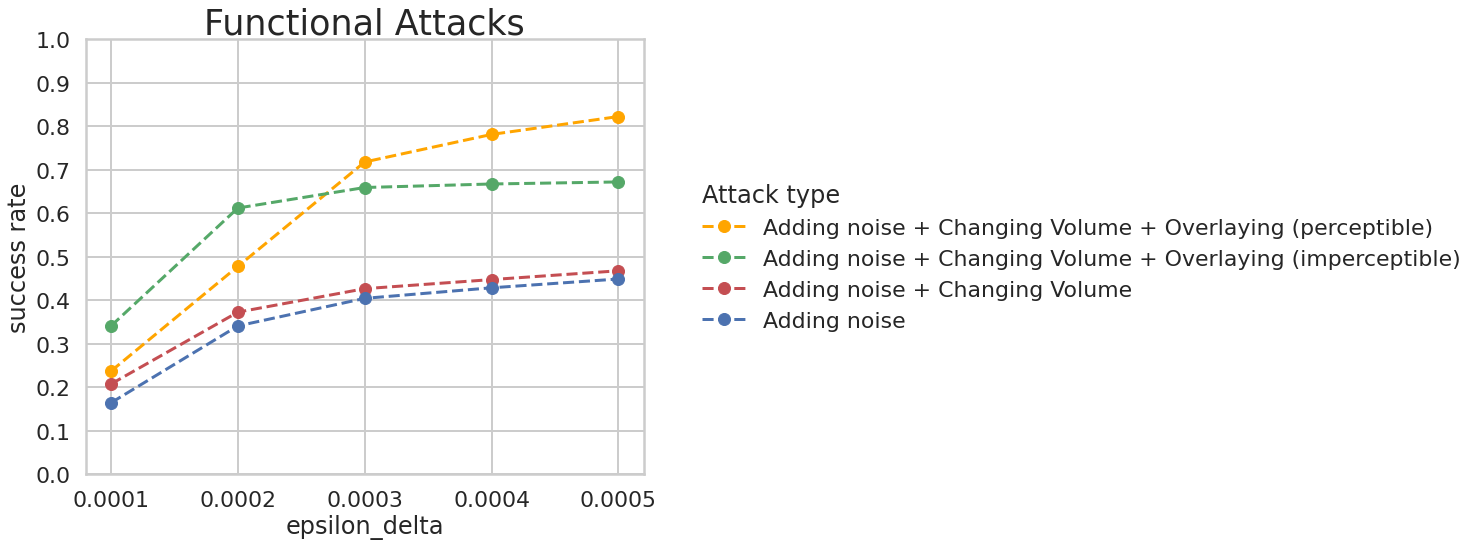

In [103]:
draw_plot(epsilons, data = [y3, y4, y2, y1], legend_x_offset=2.5, title="Functional Attacks",
          legend_title="Attack type", x_label="epsilon_delta", y_label="success rate")